# Part 1 | Augmented Reality

Steps:

1. Detect keypoints and get the best correspondences using (SIFT) and (Brute Force Matcher)
2. Compute the homography matrix (Ax=b)
3. Calculate book coordinates 
4. Crop the AR video frames to match the size of the book
5. Overlay the AR video frames on the book video

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Reading videos

In [2]:
book_video=cv2.VideoCapture("assets/AR/book.mov")
ar_video=cv2.VideoCapture("assets/AR/ar_source.mov")
book=cv2.imread("assets/AR/cv_cover.jpg",0) #gray scale

In [3]:
book_frames=[]  # append the frames 
while True:
    ret,frame=book_video.read()
    if not ret:
        break
    book_frames.append(frame)

In [4]:
ar_frames=[]
while True:
    ret,frame=ar_video.read()
    
    if not ret:
        break
    new_frame=frame[50:300,:]
    ar_frames.append(new_frame)

Extracting first frame

In [5]:
first_frame=book_frames[0]
first_frame_copy=first_frame.copy()
first_frame_gray=cv2.cvtColor(first_frame,cv2.COLOR_BGR2GRAY)
ar_frame=ar_frames[0]
book=cv2.resize(book,(first_frame.shape[1],first_frame.shape[0]))
book_copy=book.copy()

In [6]:
first_frame_rgb=cv2.cvtColor(first_frame,cv2.COLOR_BGR2RGB)
ar_frame_rgb=cv2.cvtColor(ar_frame,cv2.COLOR_BGR2RGB)

<Figure size 640x480 with 0 Axes>

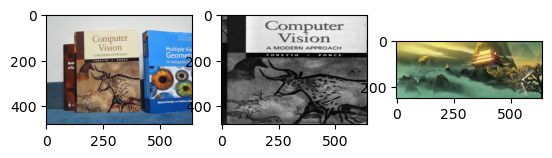

In [7]:
plt.figure()
fig, axes = plt.subplots(1, 3)

axes[0].imshow(first_frame_rgb)
axes[1].imshow(book,cmap='gray')
axes[2].imshow(ar_frame_rgb)
plt.show()


Getting correspondences

In [8]:
def find_correspondences(src_frame,dst_frame):
    sift=cv2.SIFT_create()
    #get keypoints and the descriptor from the src and dst frames
    key_points1,des1=sift.detectAndCompute(src_frame,None)  
    gray=cv2.cvtColor(dst_frame,cv2.COLOR_BGR2GRAY)
    key_points2,des2=sift.detectAndCompute(gray,None)
    bf=cv2.BFMatcher()
    #get the best '2' matches  
    matches=bf.knnMatch(des1,des2,k=2) 

    good_matches=[]
    #take a match if it is lower than certain threshold, otherwise it is an ambiguous match 
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            
            good_matches.append(m)
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    pts1 = []
    pts2 = []
    #extract the points of good matches
    for match in good_matches:
        img1_idx = match.queryIdx  
        img2_idx = match.trainIdx  

        (x1, y1) = key_points1[img1_idx].pt
        (x2, y2) = key_points2[img2_idx].pt 

        pts1.append((x1, y1))
        pts2.append((x2, y2))
 
    return pts1,pts2,key_points1,key_points2,good_matches
    
    



In [9]:
pts1,pts2,key_points1,key_points2,good_matches=find_correspondences(book,first_frame)

Extracted Key Points

In [10]:
book_features=cv2.drawKeypoints(book,key_points1,book_copy)
frame_features=cv2.drawKeypoints(first_frame_gray,key_points2,first_frame_gray)

<Figure size 640x480 with 0 Axes>

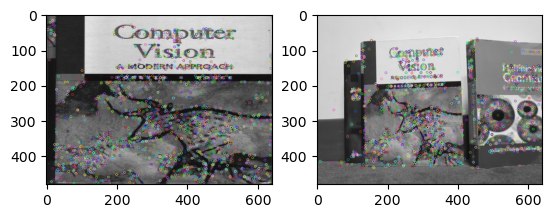

In [11]:
plt.figure()
fig, axes = plt.subplots(1, 2)

axes[0].imshow(book_features, cmap='gray')
axes[1].imshow(frame_features)
plt.show()

Feature Matching

Best matches

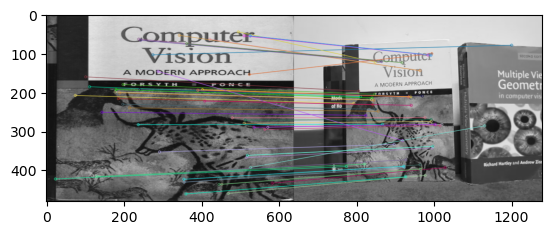

In [12]:
#draw the best matches
result=cv2.drawMatches(book,key_points1,first_frame_gray,key_points2,good_matches[:50],None,flags=2)
plt.figure()
plt.imshow(result)

Homography Matrix

In [13]:
def ransac(pts1, pts2, number, iterations, threshold):
    best_H = None
    max_inliers = 0
    np.random.seed(42)
    for _ in range(iterations):
        #sample `n` coordinates every iteration to fit the model
        index = np.random.randint(0, len(pts1), number)
        
       
        random_points_src = pts1[index, :]
        random_points_dst = pts2[index, :]

       
        A = np.zeros((2 * number, 8), dtype=np.float64)
        b = np.zeros((2 * number, 1), dtype=np.float64)
        for i in range(number):
            x, y = random_points_src[i]
            x_prime, y_prime = random_points_dst[i]

            A[2 * i]     = [x, y, 1, 0, 0, 0, -x * x_prime, -y * x_prime]
            A[2 * i + 1] = [0, 0, 0, x, y, 1, -x * y_prime, -y * y_prime]
            b[2 * i]     = x_prime
            b[2 * i + 1] = y_prime

       
        x, _, _, _ = np.linalg.lstsq(A, b, rcond=None) #solve for Ax=b
        H = np.append(x, 1).reshape(3, 3) # append H[3,3]=1

        #calculate the projected error for each point
        #inlier -> projected error less than the threshold 
        inliers = 0
        for i in range(len(pts1)):
            src = np.array([pts1[i][0], pts1[i][1], 1]).reshape(3, 1)
            dst = np.array([pts2[i][0], pts2[i][1], 1]).reshape(3, 1)
            projected = np.dot(H, src)
            projected /= projected[2]  #convert it to "heterogeneous
            error = np.linalg.norm(projected[:2] - dst[:2])
            if error < threshold:
                inliers += 1

        if inliers > max_inliers: #choose best H with maximum number of outliers 
            max_inliers = inliers
            best_H = H
    best_H/=best_H[2,2] #normalize the last element
    return best_H


Comparison between The computed homography and opencv's homography 


In [14]:
H=ransac(np.array(pts1),np.array(pts2),7,30,0.5)
H_cv, _ = cv2.findHomography(np.array(pts1), np.array(pts2), method=cv2.RANSAC)
print("Your H:\n", H)
print("cv2 H:\n", H_cv)
H_cv_normalized = H_cv / H_cv[2, 2]
diff = np.linalg.norm(H - H_cv )
print(f"Difference between H and OpenCV’s H: {diff:.4f}")


Your H:
 [[ 4.38817756e-01  8.03820013e-03  1.16811076e+02]
 [-1.79270936e-02  7.33590308e-01  7.26659940e+01]
 [-1.76262926e-05 -5.28929031e-05  1.00000000e+00]]
cv2 H:
 [[ 4.26482537e-01  6.38975617e-03  1.18505729e+02]
 [-2.72633065e-02  7.20362162e-01  7.67866072e+01]
 [-4.45041641e-05 -5.73601362e-05  1.00000000e+00]]
Difference between H and OpenCV’s H: 4.4555


Test the accuracy of the H matrix

In [15]:
cv2.imshow('image', book_copy)  
cv2.imshow('second image', first_frame_copy)  
def mouse_click(event, x, y,  
                flags, param): 
      
    
    if event == cv2.EVENT_LBUTTONDOWN: 
       
        cv2.circle(book,(x,y),2,(255,0,0),2)
        point = np.array([x, y, 1]) 
        transformed_point = H @ point 
        print((x,y),transformed_point)
        x_new = transformed_point[0] / transformed_point[2]
        y_new = transformed_point[1] / transformed_point[2]
        # x_new*=-1
        # y_new*=-1
        print(x_new,y_new)
        cv2.circle(first_frame,(int(x_new),int(y_new)),2,(255,0,0),2)
        cv2.imshow('image', book) 
        cv2.imshow('second image', first_frame)  
          
  
  
cv2.setMouseCallback('image', mouse_click) 
   
cv2.waitKey(0) 
cv2.destroyAllWindows() 

Corners

In [16]:
def get_cornerns(book,new_H):
    book_height,book_width=book.shape 
    #top left , top right , down left , down right
    corners=[(0,0),(0,book_height),(book_width,0),(book_width,book_height)]
    mapped_corners=[]
    for x,y in corners:
        point = np.array([x, y, 1]) 
        transformed_point = new_H @ point 
        x_new = transformed_point[0] / transformed_point[2]
        y_new = transformed_point[1] / transformed_point[2]
        x_new=int(x_new)
        y_new=int(y_new)
        mapped_corners.append((x_new,y_new))
        #mapped_corners=np.array(mapped_corners)
    return mapped_corners

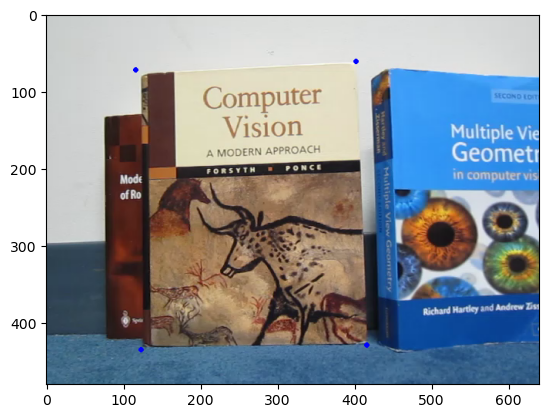

In [17]:
mapped_corners=get_cornerns(book,H)
for i in range(4):
    cv2.circle(first_frame_rgb,mapped_corners[i],2,(0,0,255),2)
plt.figure()
plt.imshow(first_frame_rgb)

Cropping

In [18]:
def crop(corners, ar_frame):
    corners = np.array(corners)
    
    book_width = int(np.linalg.norm(corners[0] - corners[1]))
    book_height = int(np.linalg.norm(corners[0] - corners[2]))
    frame_height, frame_width = ar_frame.shape[:2]
    book_aspect = book_width / book_height
    frame_aspect = frame_width / frame_height

    if frame_aspect > book_aspect:  # if the frame is wider than the book, then crop from the width, else crop from the height
       
        new_width = int(book_aspect * frame_height)
        x_start = (frame_width - new_width) // 2
        cropped = ar_frame[:, x_start:x_start + new_width]
    else:
       
        new_height = int(frame_width/ book_aspect)
        y_start = (frame_height - new_height) // 2
        cropped = ar_frame[y_start:y_start + new_height, :]
        

  
    resized = cv2.resize(cropped, (book_width, book_height))
   
    return resized


In [19]:
def warp(H, ar_frame, mapped_corners, frame,index=0,frames=None,book=None):
  
   
    mapped_corners=np.array(mapped_corners)
    book_width = int(np.linalg.norm(mapped_corners[0] - mapped_corners[1]))
    book_height = int(np.linalg.norm(mapped_corners[0] - mapped_corners[2]))
    
    if book_width < 30 or book_height < 30: #if the mapped cornerns aren't accurate, use the H from the previous frame
       
        print("⚠️ Small dimensions, using previous corners.")
       
        pts1,pts2,_,_,_=find_correspondences(book,frames[index-1])
        pts1=np.array(pts1)
        pts2=np.array(pts2)
        H=ransac(pts1,pts2,6,30,1)
        
        
        mapped_corners=get_cornerns(book,H)
      
    top_left   = mapped_corners[0]
    top_right  = mapped_corners[1]
    down_left  = mapped_corners[2]
    down_right = mapped_corners[3]
    cropped_ar_frame = crop([top_left, top_right, down_left, down_right], ar_frame) #crop using the 4 cornerns 
    cropped_ar_frame = cv2.resize(cropped_ar_frame, (frame.shape[1], frame.shape[0]))
    warped_frame = cv2.warpPerspective(cropped_ar_frame, H, (frame.shape[1], frame.shape[0]))

   
    mask = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)
    pts = np.array([top_left, top_right, down_right, down_left]) #fill the book area with white and then replace it with the ar frame
    cv2.fillConvexPoly(mask, pts.astype(int), 255)

   
    final_frame = frame.copy()
    final_frame[mask == 255] = warped_frame[mask == 255]
   
   
    
    return final_frame


Overlay the First Frame of the Two Videos

(250, 640, 3)


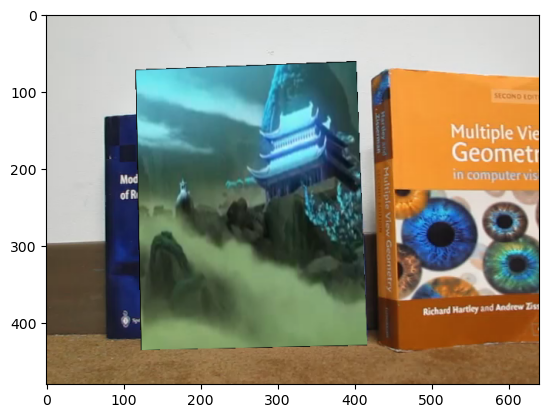

In [20]:
extracted=warp(H,ar_frames[0],mapped_corners,first_frame)
plt.figure()
plt.imshow(extracted)
print(ar_frames[0].shape)


Creating AR Application


In [21]:
new_frames=[]
length=min(len(book_frames),len(ar_frames))
# pre_H,H=None
for i in range(length):
    frame=book_frames[i]
    ar_frame=ar_frames[i]
    pts1,pts2,_,_,_=find_correspondences(book,frame)
    pts1=np.array(pts1)
    pts2=np.array(pts2)
    H=ransac(pts1,pts2,6,30,1)
    #H, _ = cv2.findHomography(np.array(pts1), np.array(pts2), method=cv2.RANSAC)
    
    corners=get_cornerns(book,H)
    
    extracted=warp(H,ar_frame,corners,frame,i,book_frames,book)
    
    new_frames.append(extracted)


⚠️ Small dimensions, using previous corners.


In [22]:
def save_video(frames, output_path, fps):
    if len(frames) == 0:
        print("No frames to save.")
        return

    height, width = frames[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
        out.write(frame)

    out.release()
    print(f"Video saved to {output_path}")
path = "output.mp4"

save_video(new_frames,path,30)

Video saved to output.mp4
